In [1]:
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import requests
import zipfile

from pathlib import Path

dataPath = Path("data")
imagePath = dataPath / "pizza_steak_sushi"

if imagePath.is_dir():
    print("Image directory already exists")
    pass
else:
    print("Image directory does not exist, creating it now...")
    imagePath.mkdir(parents=True, exist_ok=True)

    # print("Downloading data...")
    # with open(dataPath/"pizza_steak_sushi.zip", "wb") as f:
    #     r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    #     f.write(r.content)

    print("Unzipping data...")
    with zipfile.ZipFile(dataPath/"pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(imagePath)


Image directory already exists


In [4]:
import os
def walk_through_dir(path_dir):
    for dirpath, dirname, filename in os.walk(path_dir):
        print(dirpath)
        
walk_through_dir(imagePath)

data/pizza_steak_sushi
data/pizza_steak_sushi/test
data/pizza_steak_sushi/test/steak
data/pizza_steak_sushi/test/sushi
data/pizza_steak_sushi/test/pizza
data/pizza_steak_sushi/train
data/pizza_steak_sushi/train/steak
data/pizza_steak_sushi/train/sushi
data/pizza_steak_sushi/train/pizza


In [5]:
train_path, test_path = imagePath / "train", imagePath / "test"
train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

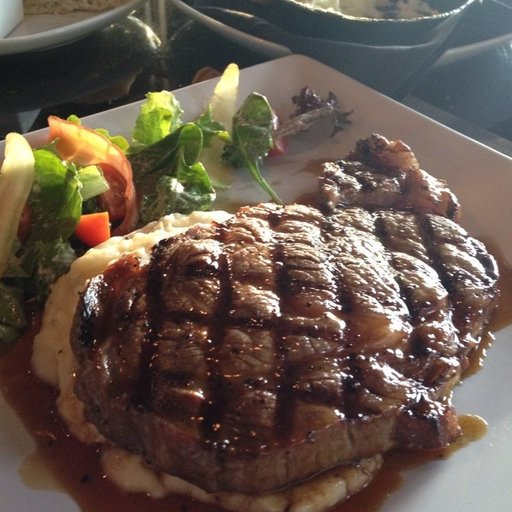

In [6]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(imagePath.glob("*/*/*.jpg"))
# image_path_list

random_img_path = random.choice(image_path_list)
random_img_label = random_img_path.parent.stem

# random_img_path, random_img_label
showcaseimg = Image.open(random_img_path)
showcaseimg

In [7]:
import numpy as np
img_array = np.asarray(showcaseimg)
img_array.shape

(512, 512, 3)

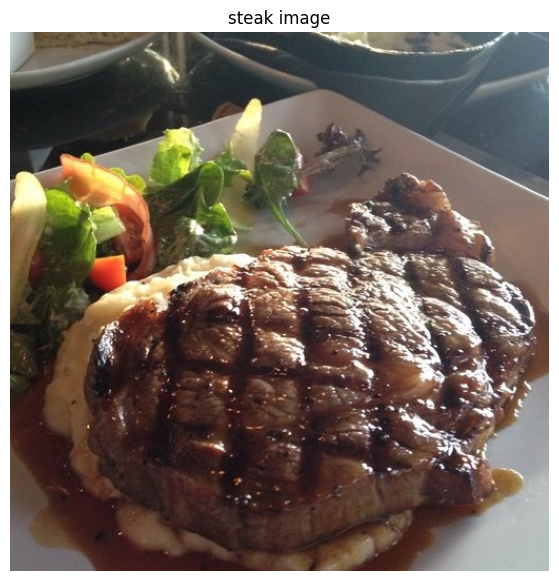

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"{random_img_label} image")
plt.axis(False);

In [9]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

trans_img = data_transform(showcaseimg)
# trans_img.shape

trans_img.permute(1, 2, 0).shape

torch.Size([64, 64, 3])

In [10]:

from torchvision import datasets

train_dataset = datasets.ImageFolder(str(train_path), 
                     transform=data_transform,
                     target_transform=None)

test_dataset = datasets.ImageFolder(str(test_path),
                        transform=data_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
class_names = train_dataset.classes
train_dataset.classes, train_dataset.class_to_idx 

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [12]:
data, label = train_dataset[0][0], train_dataset[0][1]
class_names[label]

'pizza'

(-0.5, 63.5, 63.5, -0.5)

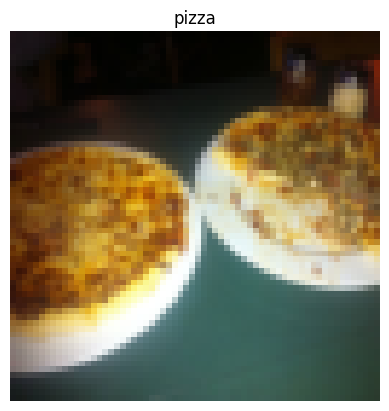

In [13]:
plt.imshow(data.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, 
                              batch_size=1,
                              shuffle=True,
                              num_workers=1)

test_dataloader = DataLoader(test_dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=1)

len(train_dataloader), len(test_dataloader)


(225, 75)

In [15]:
img_batch, label = next(iter(train_dataloader))

len(img_batch), len(label)

(1, 1)

In [16]:
img_batch.shape

torch.Size([1, 3, 64, 64])

In [17]:
from typing import Tuple, Dict, List, Any
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    class_names = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
    cls_to_idx = {class_name : i for i, class_name in enumerate(class_names)}
    
    return class_names, cls_to_idx

find_classes(str(train_path))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [18]:
from torch.utils.data import Dataset
from typing import Union

class ImageFolderCustom(Dataset):
    def __init__(self, img_path: str, transform: Union[transforms.Compose, None]):
        super().__init__()
        # self.img_path = img_path
        self.paths = list(Path(img_path).glob("*/*.jpg"))
        self.classes, self.class_to_idx = find_classes(img_path)

        self.transform = transform

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            transformed_img: torch.Tensor = self.transform(img)
            # return torch.tensor(np.asarray(img)), class_idx
            return transformed_img, class_idx
        else:
            return torch.tensor(np.asarray(img)), class_idx
            # return img, class_idx

    def __len__(self) -> int:
        return len(self.paths)
    
    def load_image(self, index: int)-> Image.Image:
        return Image.open(self.paths[index])
    
    

In [19]:
mydataset = ImageFolderCustom(str(train_path), transform=None)
# data, label
mydataset.classes, mydataset.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

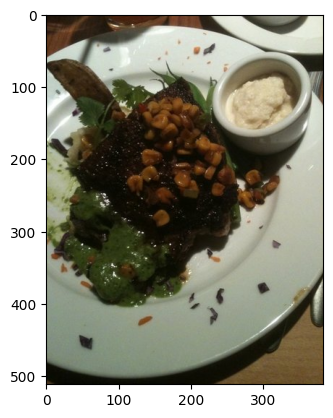

In [20]:
test_img1 = mydataset[0][0]
# test_img1 = mydataset[0][0].permute(1,2 ,0)
# test_img1.shape
plt.imshow(test_img1)

### Create TinyVGG Classes

In [21]:
from torch import nn


class TinyVGG(nn.Module):

    def __init__(self, input_chan, hidden_chan, output_features) -> None:
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_chan,
                      out_channels=hidden_chan,
                      kernel_size=3,
                      stride=1,
                      padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=hidden_chan,
                      out_channels=hidden_chan,
                      kernel_size=3,
                      stride=1,
                      padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_chan,
                      out_channels=hidden_chan,
                      kernel_size=3,
                      stride=1,
                      padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=hidden_chan,
                      out_channels=hidden_chan,
                      kernel_size=3,
                      stride=1,
                      padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_chan * 16 * 16, 
                      out_features=output_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        # print(f"after conv1 shape:  {x.shape}")
        x = self.conv_block2(x)
        # print(f"after conv2 shape:  {x.shape}")
        x = self.classfier(x)
        # print(f"after classfier shape:  {x.shape}")
        return x
        

In [22]:
example_batch = next(iter(train_dataloader))
example_batch[0].shape

torch.Size([1, 3, 64, 64])

In [23]:
model_vgg = TinyVGG(input_chan=3, hidden_chan=12, output_features=3)
model_vgg(example_batch[0])

model_vgg.state_dict()

OrderedDict([('conv_block1.0.weight',
              tensor([[[[ 0.0759, -0.0005,  0.1629],
                        [-0.1918,  0.0369,  0.0832],
                        [ 0.0137,  0.0509, -0.0005]],
              
                       [[ 0.1802, -0.0028,  0.0777],
                        [-0.0322, -0.0471, -0.1809],
                        [ 0.1126,  0.1850,  0.1848]],
              
                       [[ 0.0668, -0.0883, -0.0706],
                        [ 0.1146, -0.1559, -0.1266],
                        [ 0.0336,  0.0568,  0.0361]]],
              
              
                      [[[-0.1160, -0.1116, -0.1469],
                        [-0.1924,  0.1618, -0.0662],
                        [-0.0375, -0.0743,  0.1235]],
              
                       [[ 0.0009, -0.0745,  0.0260],
                        [ 0.1383,  0.1281,  0.0755],
                        [-0.0287, -0.0800, -0.0880]],
              
                       [[-0.1762, -0.1084,  0.0914],
                  

In [24]:
from torchinfo import summary

summary(model_vgg, input_size=(32, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 12, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 12, 64, 64]          336
│    └─ReLU: 2-2                         [32, 12, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 12, 64, 64]          1,308
│    └─ReLU: 2-4                         [32, 12, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 12, 32, 32]          --
├─Sequential: 1-2                        [32, 12, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 12, 32, 32]          1,308
│    └─ReLU: 2-7                         [32, 12, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 12, 32, 32]          1,308
│    └─ReLU: 2-9                         [32, 12, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 12, 16, 16]          --
├─Seq

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.01)



def train_step(data_loader: DataLoader, model: nn.Module,
               loss_fn: nn.CrossEntropyLoss,
               optimizer: torch.optim.Optimizer) -> Tuple[float, float]:
    model.train()

    train_loss = 0
    train_acc = 0

    print("number of data: ", len(data_loader))
    for batch_idx, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # forward
        y_hat = model(X)
        # loss
        loss = loss_fn(y_hat, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)

    return train_loss, train_acc


def test_step(data_loader: DataLoader, model: nn.Module,
              loss_fn: nn.CrossEntropyLoss) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = loss_fn(y_hat, y).item()

            test_loss += loss

            y_pred_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    # print(f"Test Error: \n Accuracy: {(100. * correct / len(data_loader)):.0f}%, Avg loss: {test_loss:.4f}\n")
    return test_loss, test_acc


In [33]:

train_step(train_dataloader, model_vgg, loss_fn, optimizer)

number of data:  225


(1.1005315282609727, 0.3377777777777778)

In [34]:
test_step(test_dataloader, model_vgg, loss_fn)

(1.0939377689361571, 0.44)

In [46]:
from tqdm.auto import tqdm

class TrainingProcess():
    def __init__(self, model, train_dataloader, test_dataloader, loss_fn, optimizer):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.result = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }

    def execute_train(self, epochs=3):
        for epoch in tqdm(range(epochs)):
            (train_loss, train_acc) = train_step(self.train_dataloader, self.model, self.loss_fn, self.optimizer)
            (test_loss, test_acc) = test_step(self.test_dataloader, self.model, self.loss_fn)

            self.result["train_loss"].append(train_loss)
            self.result["train_acc"].append(train_acc)
            self.result["test_loss"].append(test_loss)
            self.result["test_acc"].append(test_acc)

        return self

    def plot_loss_acc(self):
        epochs = range(len(self.result["train_loss"]))
        print("plot epochs: ", epochs)
        print("result: ", self.result)

        # plt.figure(figsize=(15, 7))
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))

        ax[0].title.set_text('Training and Validation loss')
        ax[0].plot(epochs, self.result["train_loss"], 'g', label='Training loss')
        ax[0].plot(epochs, self.result["test_loss"], 'b', label='Validation loss')
        ax[0].legend()

        ax[1].title.set_text('Training and Validation accuracy')
        ax[1].plot(epochs, self.result["train_acc"], 'g', label='Training acc')
        ax[1].plot(epochs, self.result["test_acc"], 'b', label='Validation acc')
        ax[1].legend()


  0%|          | 0/10 [00:00<?, ?it/s]

number of data:  225
number of data:  225
number of data:  225
number of data:  225
number of data:  225
number of data:  225
number of data:  225
number of data:  225
number of data:  225
number of data:  225
plot epochs:  range(0, 10)
result:  {'train_loss': [0.6197557451498668, 0.6025359020124865, 0.5482920370276164, 0.4641218075844477, 0.49557546269069364, 0.3193225575268136, 0.44038553233889816, 0.4352398470846371, 0.2912803329879934, 0.3046660662923523], 'train_acc': [0.7288888888888889, 0.7644444444444445, 0.7644444444444445, 0.8222222222222222, 0.8088888888888889, 0.8888888888888888, 0.84, 0.8355555555555556, 0.8888888888888888, 0.9066666666666666], 'test_loss': [1.4669140035814294, 1.3702792446129024, 1.5159120477860173, 1.848993534265707, 1.2444298337896664, 1.815435247666513, 2.025429813870384, 2.194843086148224, 2.251828481729996, 2.0791604456649897], 'test_acc': [0.41333333333333333, 0.4, 0.44, 0.41333333333333333, 0.48, 0.44, 0.4, 0.41333333333333333, 0.48, 0.506666666666

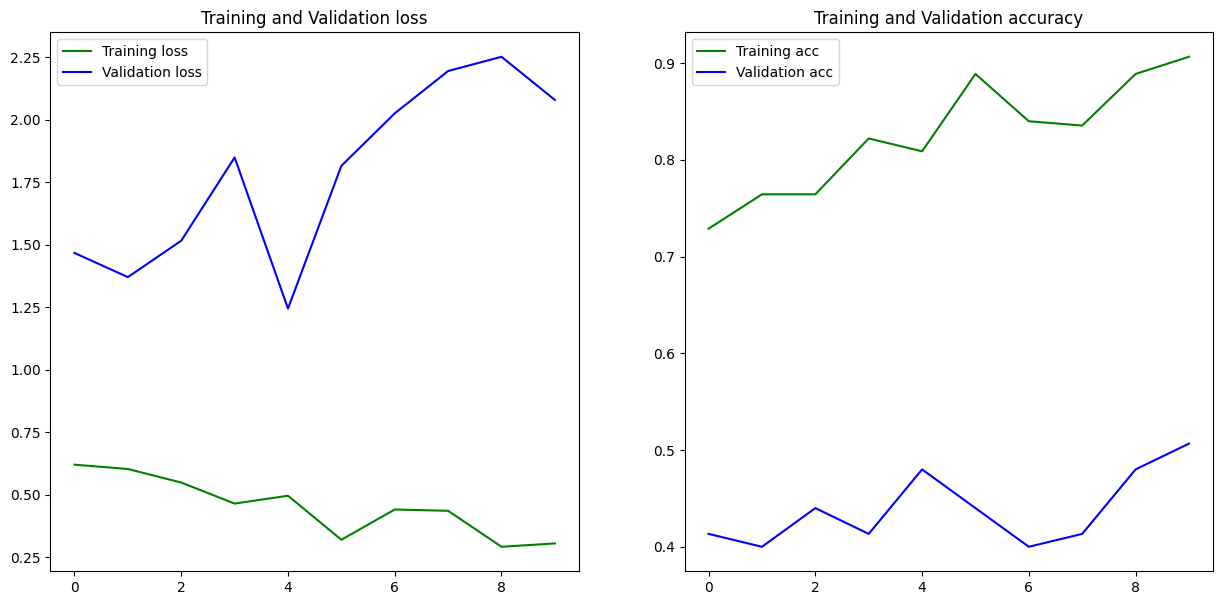

In [48]:
trainExecuter = TrainingProcess(model_vgg, train_dataloader, test_dataloader, loss_fn, optimizer)

trainExecuter.\
    execute_train(epochs=10).\
    plot_loss_acc()